# Exploratory Data Analysis with BERT Vectors

Prerequisites: 

1. Enable [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/user_install.html) in this notebook by running the command:

    ```
    $ jupyter nbextension enable --py widgetsnbextension
    ```

### Initialize DataLoader and BERT Models

In [1]:
import yaml
import torch
import sqlite3

from dataset.sqlite_text_dataset import SQLiteTextDataset

with open('.notebook_conf.yml', 'r') as fp:
    config = yaml.load(fp, Loader=yaml.FullLoader)

dataset = SQLiteTextDataset(
        config['database_file'], config['database_table'], 
        config['vocab_file'])

dataloader = dataset.build_dataloader(batch_size=512, shuffle=True)

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')

/home/dylan/python-venv/s2v/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
Using cache found in /home/dylan/.cache/torch/hub/huggingface_pytorch-transformers_master
Using cache found in /home/dylan/.cache/torch/hub/huggingface_pytorch-transformers_master
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel fr

### Encode Sentence Representations With BERT Model

In [2]:
batch = next(iter(dataloader))

embeds = []

for question in batch['question_str']:
    text_1 = question
    text_2 = None

    indexed_tokens = tokenizer.encode(text_1, text_2, add_special_tokens=True)

    where_sep = indexed_tokens.index(102)

    segmented_ids = ([0] * len(indexed_tokens[:where_sep])) + ([1] * len(indexed_tokens[where_sep:]))

    segments_tensor = torch.tensor([segmented_ids])
    tokens_tensor = torch.tensor([indexed_tokens])

    with torch.no_grad():
        outputs = model(tokens_tensor, token_type_ids=segments_tensor)
        
        # average the second to last hidden layer of each token for findal output vec
        sentence_embedding = torch.mean(outputs[-2][0], dim=0, keepdim=True)
        
    embeds.append(sentence_embedding)
    
embeds = torch.cat(embeds).numpy()

### Cluster Embeddings

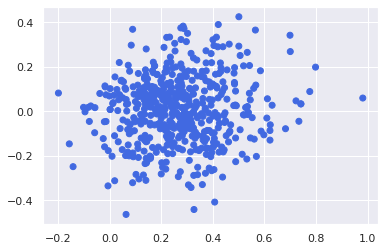

In [4]:
from sklearn.cluster import OPTICS
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

X = embeds

optics = OPTICS(min_samples=5)
optics.fit(X)
labels = optics.labels_

colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(X[:,0], X[:,1], c=vectorizer(labels))

### Project Embeddings With T-SNE